# Import packages

### Import python packages

In [1]:
import re,os,glob
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
from MRA_generate import MRA_generate
from parameters import *
import symae_core as symae
from movie_redatum import movie_redatum 

# Generate dataset X

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.compat.v1.Session(config = config)

2022-08-21 23:31:53.574327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 23:31:54.314294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14505 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b1:00.0, compute capability: 8.6


### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==0:
        return int(x<0.5)
    elif n==1:
        return math.cos(2*math.pi*x)/2 + 0.5
    elif n==2:
        if x<0.5: 
            return 1-2*x
        else:     
            return 0
    elif n==3:
        return 2*int(x<0.5)-1
    elif n==4:
        return math.cos(2*math.pi*x)
    elif n==5:
        if x<0.5: 
            return 1-4*x
        else:     
            return -1
#def g(n,x):
#    return math.e**(-(n+1)*(x-0.5)**2)

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 6 states')

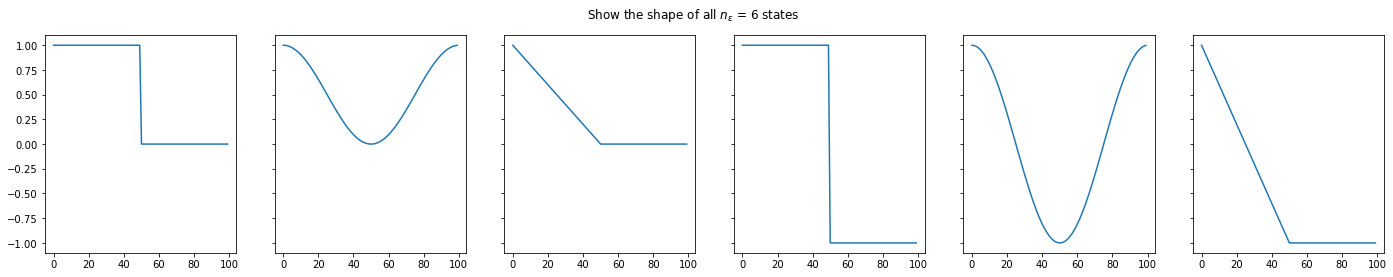

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [5]:
MRA_training = MRA_generate(d,nt,N,0,ne,g,replace=2,continuous=False)
MRA_training.generate_default()
X = MRA_training.X
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

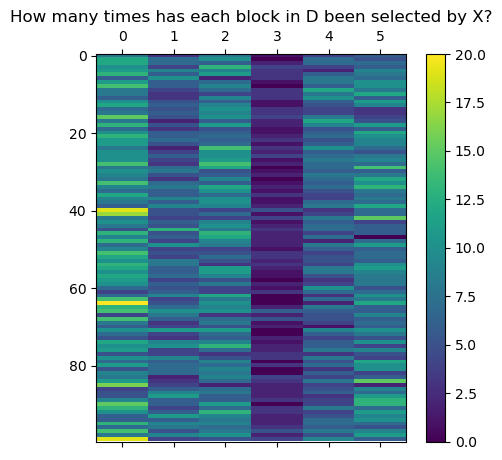

In [6]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [7]:
nt

200

### Layer

In [8]:
@tf.function
def bernoulli_mask(n, k):
    indices = tf.math.top_k(tf.random.uniform(shape=[n]), k, sorted=False).indices
    indices = tf.cast(indices, tf.int64)
    indices = tf.stack([indices, tf.zeros_like(indices)], axis=-1)
    out = tf.sparse.SparseTensor(indices=indices, values=tf.ones(indices.shape[0]), 
                                 dense_shape=[n,1])
    out = tf.sparse.reorder(out)
    return tf.sparse.to_dense(out)[:,0]
class My_Dropout(tf.keras.Model):
    '''WARNING: this layer highly rely on broadcasting'''
    def __init__(self, remain=1):
        super(My_Dropout, self).__init__(name='')
        self.remain = remain
    def call(self, x, training=False):
        #self.remain = tf.math.count_nonzero(tf.random.uniform([q])>0.5)
        if training==True:
            mask = bernoulli_mask(x.shape[-1], self.remain)
        elif training==False:
            mask = tf.ones_like(x)
        #tf.print(self.remain)
        z = x*mask
        return z

In [9]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=0.5):
        super(LatentCat, self).__init__(name = 'latentcat')
        self.drop = tfkl.GaussianDropout(alpha)
        #self.drop = My_Dropout(2)
    def call(self, zsym, znuisance, training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [10]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, d, p, q, r): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = symae.SymmetricEncoder1D(p)
        self.sym_encoder = sym_encoder
        
        # Build nuisance encoder
        nui_encoder = symae.NuisanceEncoder1D(q)
        self.nui_encoder = nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.Mixer1D(d)
        self.mixer = mixer
        
        # Build latentcat
        latentcat = LatentCat(r)
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym,znuisance)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder = encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output = mixer(distzsym(decoder_input))
        decoder = tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder = decoder
        
    def call(self, x):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

### Initialize SymAE and load weights

In [11]:
my_list=[(10, 10, 0.5, 0)]

In [12]:
for (p,q,r,lam) in my_list:
    path = './drop,p=%d,q=%d,r=%.1f,l=%.2f'%(p,q,r,lam)    
    #import symae_model 
    model = SymAE(N,nt,d,p,q,r)
    #model = symae_model.SymAE(N,nt,d,p,q,5,64,0.0)
    clear_output()
    #lam=10
    try: 
        model.load_weights(path+'/checkpoint')
        print("old")    
    except:
        print("new")
    optimizer = tf.keras.optimizers.Adam(0.001)
    mse = tf.keras.losses.MeanSquaredError()

    def reconstruction_loss(model, x, training=False):
        x_hat = model(x, training=True)
        return mse(x, x_hat)
    def norm(x, ord=1.8, axis=-1):
        if ord==1:
            return tf.math.abs(x,axis=axis)
        elif ord==2:
            return tf.sqrt(tf.reduce_sum(tf.square(x), axis=axis) + 1.0e-12)
        else:
            return tf.math.pow(tf.reduce_sum(tf.square(x), axis=axis) + 1.0e-12, ord/2)
    @tf.function
    def set_distance(s1,s2):
        ''' |s1|=N*|s2| '''
        '''WARNING: this layer rely on broadcasting'''
        s1_ = tf.expand_dims(s1, 0)
        s1__ = tf.expand_dims(s1, 1)
        s2_ = tf.expand_dims(s2, 0)
        s2__ = tf.expand_dims(s2, 1)
        s12 = tf.reduce_mean(norm(s1_-s2__, axis=-1))
        s11 = tf.reduce_mean(norm(s1_-s1__, axis=-1))
        s22 = tf.reduce_mean(norm(s2_-s2__, axis=-1))
        s = s12-s11/2-s22/2
        return s
    def mutual_info_penalty(model, x, training=False):
        z = model.encoder(x, training=False)
        coherent_code = z[:,0:p]
        nuisance_code = z[:,p:p+nt*q]
        all_points = tf.reshape(nuisance_code,[-1,q])
        std = tf.math.reduce_std(all_points, 0)
        std = tf.ones_like(std)
        s = 0.0
        for i in trange(z.shape[0]):
            s += set_distance(all_points, all_points[i*nt:(i+1)*nt,:])
        return s
    @tf.function
    def train_step(model, x, training=True):
        with tf.GradientTape() as tape:
            loss_rec = reconstruction_loss(model, x, training)
            loss_cor = mutual_info_penalty(model, x, training)*lam
            loss = loss_rec + loss_cor
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss_rec, loss_cor

    try:
        os.mkdir(path)
    except:
        print('exists')

    try:
        epoch = int(re.findall(r"\d+",glob.glob(path+'/*.epoch')[0])[-1])
        print(epoch)
    except:
        epoch = 0
        os.mkdir(path+'/0.epoch')
    MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=2,continuous=False)
    MRA_test.generate_default()
    clear_output()
    N_states = np.repeat(MRA_test.states,nt)
    N_shifts = MRA_test.shifts.reshape(-1,1)
    df_states = pd.DataFrame(1+N_states,columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
    for i in range(10000):
        epoch += 1
        os.mkdir(path+'/%d.epoch'%epoch)
        os.rmdir(path+'/%d.epoch'%(epoch-1))    
        loss_rec, loss_cor = train_step(model, X)
        print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
              .format(epoch, loss_rec, loss_cor))
        clear_output(wait=True)

    model.save_weights(path+'/checkpoint')
    print("weights saved")

    fig = movie_redatum(g,model)
    fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

    N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
    N_reshaped = N_code.reshape(-1,q)
    pca_N = PCA(2).fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    df = df.sort_values(by=['state'])
    fig = px.scatter(df, x='first principal component', y='second principal component', 
                     color='state', text='shift')
    fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
    fig.show()
    fig.write_image(path+'/latent.pdf')

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 306.36it/s]
2022-08-21 23:32:09.836639: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 128.00M (134217728 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-08-21 23:32:09.854611: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-08-21 23:32:09.854689: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.
2022-08-21 23:32:09.861619: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-08-21 23:32:09.861674: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.
2022-08-21 23:32:09.868459: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-08-21 

UnimplementedError: Graph execution error:

Detected at node 'encoder/nui_encoder/time_distributed_6/conv1d_8/Conv1D' defined at (most recent call last):
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_423240/394460368.py", line 82, in <cell line: 1>
      loss_rec, loss_cor = train_step(model, X)
    File "/tmp/ipykernel_423240/394460368.py", line 54, in train_step
      loss_cor = mutual_info_penalty(model, x, training)*lam
    File "/tmp/ipykernel_423240/394460368.py", line 40, in mutual_info_penalty
      z = model.encoder(x, training=False)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/github/SymAE/MRA/with_noise/symae_core.py", line 27, in call
      x=self.c1(x)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/layers/rnn/time_distributed.py", line 221, in call
      y = self.layer(inputs, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'encoder/nui_encoder/time_distributed_6/conv1d_8/Conv1D'
DNN library is not found.
	 [[{{node encoder/nui_encoder/time_distributed_6/conv1d_8/Conv1D}}]] [Op:__inference_train_step_8863]

In [ ]:
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
pca_N = PCA(2).fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
df = pd.concat([df,df_states,df_shifts],axis=1)
df = df.sort_values(by=['state'])
fig = px.scatter(df, x='first principal component', y='second principal component', 
                 color='state', text='shift')
fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
fig.show()
fig.write_image(path+'/latent.pdf')

In [ ]:
fig = movie_redatum(g,model)
#fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

In [ ]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
C_code = model.sym_encoder.predict(MRA_test.X,verbose=0)
C_reshaped = C_code.reshape(-1,p)

In [ ]:
pca = PCA(n_components=2)
pca_C = pca.fit_transform(C_reshaped)
df = pd.DataFrame(pca_C, columns = ['first principal component','second principal component'])
tem = pd.DataFrame(MRA_test.states+1,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
df = df.sort_values(by=['state'])
fig = px.scatter(df, x='first principal component', y='second principal component', 
                 color='state')
fig.update_layout(width=500, height=400, title="PCA of latent coherent codes")
fig.show()
fig.write_image(path+'/coherent.pdf')